# Estimating sea ice thickness with ICESat-2



* Author: Alek Petty (www.alekpetty.com)  
* Description: Jupyter Notebook to showcase the conversion of ICESat-2 sea ice freeboard (ATL10) to sea ice thickness using NESOSIM snow depth/density, including random/systematic uncertainity estimates. Notebook produced as part of OceanUQ, a US CLIVAR Working Group on uncertainty quantification in ocean observational and model data.

* Input requirements: An example ATL10 data file, NESOSIM snow depth/density, utils.py (Python script containing additional functions).   
* Date created: April 2021  

Reference: Petty, A. A., N. T. Kurtz, R. Kwok, T. Markus, T. A. Neumann (2020), Winter Arctic sea ice thickness from ICESat‐2 freeboards, Journal of Geophysical Research: Oceans, 125, e2019JC015764. doi:10.1029/2019JC015764 


## Notebook objectives
* General understanding of converting ICESat-2 sea ice freeboards to thickness
* Show the basic method for estimating sea ice thickness uncertainties



In [1]:
# Dependencies
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import cartopy.crs as ccrs
import h5py
import scipy
from astropy.time import Time
import utils as ut

#Magic function to enable interactive plotting in Jupyter notebook
%matplotlib inline

#### Import Data

As in the ATL07 Notebook, you can either get the data for this tutorial from the tutorial-data/sea-ice/ folder (at the hackweek) or download from NSIDC if you are running this on your local machine

## ICESat-2 freeboards (ATL10)

ATL10 is a pretty simple product, with most of the hard work done in ATL03 and then ATL07. ATL10 essentially returns the freeboard of the height segments calculated in ATL07 - the difference in height between the ice and sea surface. A local sea surface height is calculated in 10 km along-track sections using all relevant sea surface heights (ssh_flag) in each beam. 

A lot of the important variables in ATL07 have been passed through to ATL10 making this a useful high-level data product of interest to the community.

In [2]:
data_loc='./'
fname='ATL10-01_20191014090019_02670501_003_03.h5'
fileT= data_loc+fname

#### Read in the data using the Pandas ATL10 reader.

* Take a look at the top few rows (change the number in head to increase this, or switch to tail to show the end)    
* This includes core-variables I think are needed, but easy to add other variables you might want to use!

In [3]:
beamStr='gt1r'
epsg_string='3411'
dF10 = ut.get_atl10_freeboards(fileT, beamStr, epsg_string=epsg_string)
dF10.head()

ATL10 file: ./ATL10-01_20191014090019_02670501_003_03.h5


,freeboard,freeboard_sigma,freeboard_quality,ssh_flag,lon,lat,height_segment_id,datetime,seg_x,xpts,ypts
0,0.070049,0.006201,1,0,-177.077722,77.459490,832,2019-10-14 09:20:35.743644,8650.004828,-1.012217e+06,913893.214366
1,0.074620,0.006504,1,0,-177.077763,77.459538,833,2019-10-14 09:20:35.744407,8650.010248,-1.012212e+06,913890.420752
2,0.068703,0.006655,1,0,-177.077790,77.459570,834,2019-10-14 09:20:35.744926,8650.013936,-1.012209e+06,913888.518426
3,0.055449,0.005919,1,0,-177.077817,77.459603,835,2019-10-14 09:20:35.745442,8650.017607,-1.012206e+06,913886.623731
4,0.074774,0.005591,1,0,-177.077842,77.459631,836,2019-10-14 09:20:35.745904,8650.020891,-1.012203e+06,913884.929978


In [4]:
date_str = dF10.datetime.iloc[0].strftime("%Y%m%d") 
print('Start date of granule', date_str)

Start date of granule 20191014


#### Map the data using Cartopy 
* Just a quick visual check of the freeboards. Note the gaps, mainly due to clouds!
* Note: Basemap is often used for mapping but is not being officially supported by the community anymore so we've tried to focus on Cartopy here

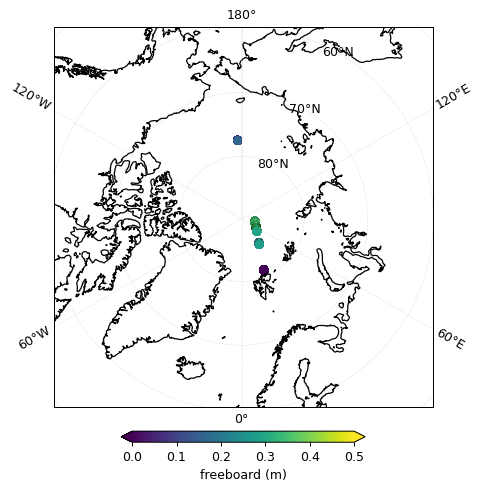

In [5]:
var='freeboard'
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
# ccrs.PlateCarree
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(dF10['lon'], dF10['lat'],c=dF10[var], cmap='viridis', vmin=0, vmax=0.5, transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
ax.gridlines(draw_labels=True,
              linewidth=0.22, color='gray', alpha=0.5, linestyle='--')
plt.colorbar(label=var+' (m)', shrink=0.5, pad=0.05, orientation="horizontal", extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

#### Convert the ATL10 freeboards to sea ice thickness!

* First we read in NESOSIM snow depth and density data to each ATL10 freeboard segment (https://github.com/akpetty/NESOSIM)
* Convert the freeboard to thickness using NESOSIM snow loading. The function this calls assumes the sea ice is in hydrostatic equlibirum. Why/when might this be invalid?


In [6]:
# First grab and apply the relevant NESOSIM snow depth and density

nesosim_path = './NESOSIMv11_01092019-30042020.nc'
# Get NESOSIM data for the given day
nesosim_day=ut.get_nesosim(date_str, nesosim_path)

dF10 = ut.grid_NESOSIM_to_freeboard(dF10, nesosim_day, epsg_string = epsg_string, outSnowVar='snow_depth_N', outDensityVar='snow_density_N', returnMap=False)

dF10.head()

./NESOSIMv11_01092019-30042020.nc
<xarray.Dataset>
Dimensions:            (x: 90, y: 90)
Coordinates:
    day                int32 20191014
Dimensions without coordinates: x, y
Data variables: (12/13)
    projection         int32 ...
    forcings           int32 ...
    parameters         int32 ...
    longitude          (x, y) float32 ...
    latitude           (x, y) float32 ...
    xgrid              (x, y) float32 ...
    ...                 ...
    snow_depth         (x, y) float32 ...
    snow_volume        (x, y) float32 ...
    snow_density       (x, y) float32 ...
    snowfall           (x, y) float32 ...
    ice_concentration  (x, y) float32 ...
    wind_speed         (x, y) float32 ...
Attributes:
    reference:    github.com/akpetty/NESOSIM
    contact:      alek.a.petty@nasa.gov
    description:  Daily snow on sea ice (depth and density) from the NASA Eul...
    history:      Created 04/03/21
    data_range:   Date range: 20190901-20200430


,freeboard,freeboard_sigma,freeboard_quality,ssh_flag,lon,lat,height_segment_id,datetime,seg_x,xpts,ypts,snow_depth_N,snow_density_N
0,0.070049,0.006201,1,0,-177.077722,77.459490,832,2019-10-14 09:20:35.743644,8650.004828,-1.012217e+06,913893.214366,0.0489,224.132401
1,0.074620,0.006504,1,0,-177.077763,77.459538,833,2019-10-14 09:20:35.744407,8650.010248,-1.012212e+06,913890.420752,0.0489,224.132401
2,0.068703,0.006655,1,0,-177.077790,77.459570,834,2019-10-14 09:20:35.744926,8650.013936,-1.012209e+06,913888.518426,0.0489,224.132401
3,0.055449,0.005919,1,0,-177.077817,77.459603,835,2019-10-14 09:20:35.745442,8650.017607,-1.012206e+06,913886.623731,0.0489,224.132401
4,0.074774,0.005591,1,0,-177.077842,77.459631,836,2019-10-14 09:20:35.745904,8650.020891,-1.012203e+06,913884.929978,0.0489,224.132401


In [7]:
# rhoi=1 is the ice density option where density is fixed at 916 (not ice type dependent like the other options available)
dF10=ut.convert_to_thickness(dF10, snowDepthVar='snow_depth_N', 
                                 snowDensityVar='snow_density_N',
                                 outVar='ice_thickness_N', rhoi=1)

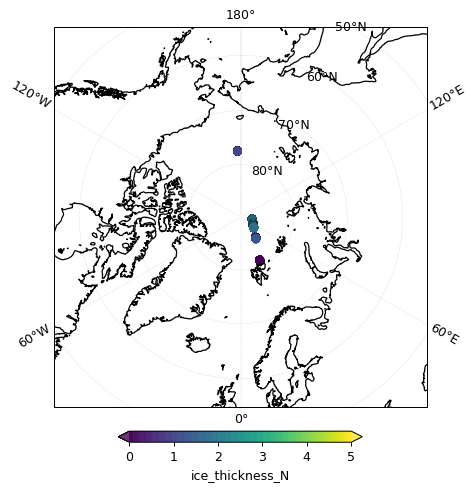

In [8]:
# Map the data for visual inspection using Cartopy
var='ice_thickness_N'
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(dF10['lon'], dF10['lat'],c=dF10[var], cmap='viridis', vmin=0, vmax=5, alpha=0.8, transform=ccrs.PlateCarree())

ax.coastlines()
ax.gridlines(draw_labels=True,
              linewidth=0.22, color='gray', alpha=0.5, linestyle='--')
plt.colorbar(label=var, shrink=0.5, pad=0.05, orientation="horizontal", extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 55], ccrs.PlateCarree())

#### Estimate sea ice thickness uncertainty

* Created a function that can either read in lists of snow depth/density and ice density assumptions to derive systematic uncertainty, or simply presribe this as a fixed value across all segments (e.g. 50 cm)
* Check out the function in utils.py and play around with assigning different individual uncertainity estimates. 

In [9]:
print(ut.calc_thickness_uncertainty.__doc__)

 Calculate sea ice thickness uncertainty using simple error propogation. 

        The approach and justificaiton is described more in Petty, A. A., N. T. Kurtz, R. Kwok, T. Markus, T. A. Neumann (2020), 
        Winter Arctic sea ice thickness from ICESat‐2 freeboards, Journal of Geophysical Research: Oceans, 125, e2019JC015764. doi:10.1029/2019JC015764 


        Args:
            dF (dataframe): dataframe containing the data
            snowDepthVar (str): snow depth variable of choosing
            snowDensityVar (str): snow density variable of choosing
            outVar (str): output string
            rhoi (int): ice density option
        Optional args:
            snow_depth_assumptions (list): list of snow depth assumptions included as columns in the dataframe
            snow_density_assumptions (list): list of snow density assumptions included as columns in the dataframe
            ice_density_assumptions (list): list of ice density assumptions included as columns in the d

In [10]:
dF10 = ut.calc_thickness_uncertainty(dF10, 'snow_depth_N', 'snow_density_N', 'ice_density_1', 'ice_thickness_N_unc', 
                                     snow_depth_unc_sys_default=0.1, snow_density_unc_sys_default=30, ice_density_unc_sys_default=10, 
                                     freeboard_unc_sys_default=0.01, seawater_density=1024., snow_depth_unc_random=0.05, snow_density_unc_random=40, 
                                     ice_density_unc_random=10., water_density_unc_random=0.5)
dF10.head()

,freeboard,freeboard_sigma,freeboard_quality,ssh_flag,lon,lat,height_segment_id,datetime,seg_x,xpts,ypts,snow_depth_N,snow_density_N,ice_density_1,ice_thickness_N,freeboard_unc,ice_thickness_N_uncrandom,ice_thickness_N_uncsys,ice_thickness_N_unc
0,0.070049,0.006201,1,0,-177.077722,77.459490,832,2019-10-14 09:20:35.743644,8650.004828,-1.012217e+06,913893.214366,0.0489,224.132401,916.0,0.302004,0.011767,0.376425,0.747310,0.836760
1,0.074620,0.006504,1,0,-177.077763,77.459538,833,2019-10-14 09:20:35.744407,8650.010248,-1.012212e+06,913890.420752,0.0489,224.132401,916.0,0.345349,0.011929,0.377203,0.747470,0.837254
2,0.068703,0.006655,1,0,-177.077790,77.459570,834,2019-10-14 09:20:35.744926,8650.013936,-1.012209e+06,913888.518426,0.0489,224.132401,916.0,0.289248,0.012012,0.377035,0.747266,0.836996
3,0.055449,0.005919,1,0,-177.077817,77.459603,835,2019-10-14 09:20:35.745442,8650.017607,-1.012206e+06,913886.623731,0.0489,224.132401,916.0,0.163575,0.011620,0.375281,0.746940,0.835915
4,0.074774,0.005591,1,0,-177.077842,77.459631,836,2019-10-14 09:20:35.745904,8650.020891,-1.012203e+06,913884.929978,0.0489,224.132401,916.0,0.346808,0.011457,0.375896,0.747476,0.836671


In [11]:
# Zoom in on the cloud-free region in the central Arctic
minlat=87.5
maxlat=90
dF10=dF10[(dF10.lat>minlat)&(dF10.lat<maxlat)]

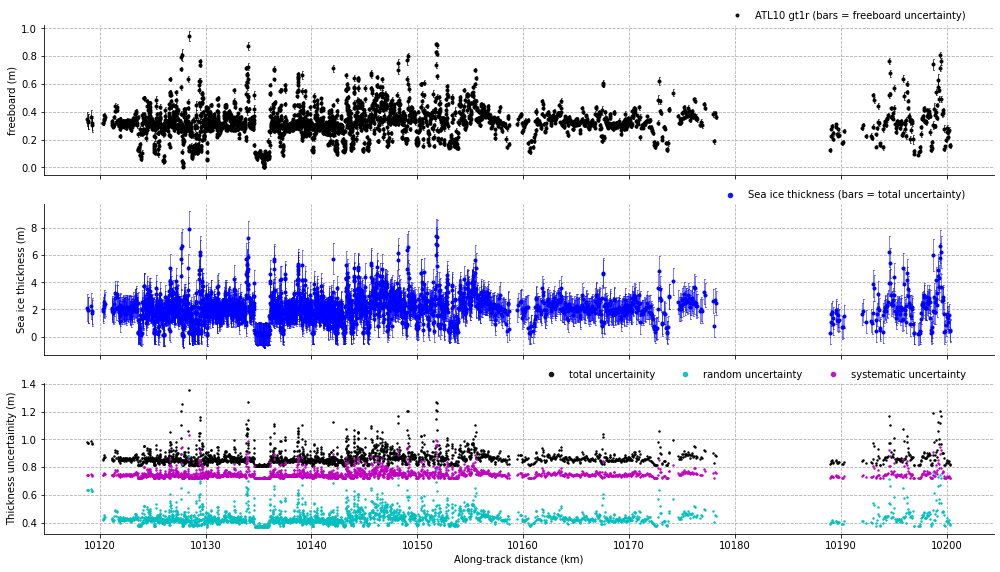

In [12]:
# Plot the time-series of freeboard (bars show freeboard uncertainity), thickness and the thickness uncertainity (contributions from random and systematic uncertainty)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))

plt.sca(axs.flatten()[0])
ax1=plt.gca()
ax1.plot(dF10['seg_x'].values, dF10['freeboard'].values, '.', color='k', alpha=0.9, label='ATL10 '+beamStr+' (bars = freeboard uncertainty)', markersize=2, linewidth=1)
ax1.errorbar(dF10['seg_x'].values, dF10['freeboard'].values, yerr=dF10['freeboard_sigma'].values, fmt='', linestyle='', marker='.', color='k', lw=0.7, capsize=0.5)

# add panel indicating ice type
ax1.set_ylabel('freeboard (m)')
#ax1.set_yticks(np.arange(0, 1.5, 0.5))
ax1.set_xticklabels([])

plt.sca(axs.flatten()[1]) 
ax2=plt.gca()

ax2.plot(dF10['seg_x'].values, dF10['ice_thickness_N'].values, '.', color='b', alpha=0.9,label=r'Sea ice thickness (bars = total uncertainty)', markersize=3, linewidth=1)
ax2.errorbar(dF10['seg_x'].values, dF10['ice_thickness_N'].values, yerr=dF10['ice_thickness_N_unc'].values, fmt='', linestyle='', marker='.', color='b', lw=0.5, capsize=0.5,)
#ax1.errorbar(dist, IS2data['ice_thickness_N'].values, yerr=IS2data['freeboard_sigma'].values, fmt='', linestyle='', marker='.', color='k', lw=0.5, capsize=0.5,)

ax2.set_ylabel('Sea ice thickness (m)')
ax2.set_xticklabels([])


plt.sca(axs.flatten()[2]) 
ax3=plt.gca()
ax3.plot(dF10['seg_x'].values, dF10['ice_thickness_N_unc'].values, '.', alpha=0.9, label='total uncertainity', color='k', markersize=3, linewidth=1)
ax3.plot(dF10['seg_x'].values, dF10['ice_thickness_N_uncrandom'].values, '.', alpha=0.9, label='random uncertainty', color='c', markersize=3, linewidth=1)
ax3.plot(dF10['seg_x'].values, dF10['ice_thickness_N_uncsys'].values, '.', alpha=0.9, label='systematic uncertainty', color='m', markersize=3, linewidth=1)

ax3.set_ylabel('Thickness uncertainity (m)')
ax3.set_xlabel('Along-track distance (km)')

ax1.legend(loc=1, ncol=1, markerscale=3, bbox_to_anchor=[0.98, 1.15], labelspacing=0.45, frameon=False)
ax2.legend(loc=1, ncol=6, markerscale=3, bbox_to_anchor=[0.98, 1.15], labelspacing=0.45, frameon=False)
ax3.legend(loc=1, ncol=6, markerscale=3, bbox_to_anchor=[0.98, 1.15], labelspacing=0.45, frameon=False)

# Common subplot additions
for ax in axs.flatten():
    plt.sca(ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    #ax.set_xlim([0, 1000])
    ax.yaxis.set_ticks_position('left')
    ax.grid(axis='both', linestyle='--')

#ax1.annotate(titleStr, xy=(0.01, 1.01), xycoords='axes fraction', horizontalalignment='left', verticalalignment='bottom')
plt.tight_layout()
#subplots_adjust(left = 0.07, right = 0.98, bottom=0.07, top = 0.96, hspace=0.18)
plt.show()
